# Import libraries

In [823]:
# uncomment to install libraries
# ! pip install numpy pandas matplotlib seaborn nltk sklearn regex geopy patsy
# ! python -m spacy download en_core_web_sm
# nltk.download("stopwords")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import patsy
import re
import geopy
from geopy import distance

# English stop words
english_stop_words = nltk.corpus.stopwords.words("english")

# word net
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nicholasmichalak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Seaborn look

In [788]:
sns.set(context = "notebook", style = "darkgrid", palette = "colorblind", font = "sans-serif")

# Define functions

## Text processing
* Special characters
* Lower case
* White space
* Tokenize with WordPunctTokenizer
* Remove English stop words
Source: [Traditional Methods for Text Data by Dipanjan (DJ) Sarkar
](https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41)

In [789]:
# process a single document's text
def process_document(document):
    # remove special characters
    document_processed = re.sub(pattern = "[^a-zA-Z0-9_\s]", repl = "", string = document, flags = re.IGNORECASE|re.ASCII)
    
    # lower case
    document_processed = document_processed.lower()
    
    # remove white space
    document_processed = document_processed.strip()
    
    # tokenize document
    tokens = nltk.WordPunctTokenizer().tokenize(document_processed)
    
    # filter stopwords out of document and lemmatize
    tokens_processed = [WordNetLemmatizer().lemmatize(token) for token in tokens if token not in english_stop_words and len(token) > 2]
    
    # re-create document from filtered tokens and return
    return " ".join(tokens_processed)

# vectorize process_document for processing entire corpus of documents
process_corpus = np.vectorize(process_document)

## Other

In [790]:
# Geocoder using the Google Maps v3 API
api_key = open("google_maps_api_key.txt").readlines()[0]
googlev3_locator = geopy.geocoders.GoogleV3(api_key = api_key)

# address, latitude, and longitude
def get_lat_long(address):
    # look up location
    location = googlev3_locator.geocode(address)
    return location.address, location.latitude, location.longitude

# euclidean distances
def pairwise_dist(data_frame, features, index):
    # full dataset of features, replace "None" with None
    X_full = data_frame.loc[:, features].mask(data_frame.loc[:, features].eq("None"))

    # imputer parameters (default estimator is BayesianRidge())
    imputer = IterativeImputer(max_iter = 10, random_state = 39248)

    # fit imputation model
    imputer_fit = imputer.fit(X_full)

    # predict missing values
    X_predict = imputer_fit.transform(X_full)
    
    # distance matrix
    dist_matrix = pd.DataFrame(
    # euclidian distances
    sklearn.metrics.pairwise.euclidean_distances(
        # standardize ((x - mean / sd))
        sklearn.preprocessing.StandardScaler().fit_transform(X_predict)
    ))
    
    # add columns and index
    dist_matrix.columns = data_frame[index]
    dist_matrix.index = data_frame[index]
    
    return dist_matrix

# Read data
* State and city data
* Room data (e.g., address, fear level, success rate)
* Reviews
* Tags

## State and city data

In [791]:
state_city_room_url = pd.read_csv("data/state_city_room_url_df.csv")

# See it
state_city_room_url

,state,city,company_and_room,woe_room_url
0,Alabama,Auburn,Auburn Escape Zones: Imprisoned,https://worldofescapes.com/auburn/quests/aubur...
1,Alabama,Auburn,Auburn Escape Zones: The Cabin,https://worldofescapes.com/auburn/quests/aubur...
2,Alabama,Auburn,Auburn Escape Zones: Vault,https://worldofescapes.com/auburn/quests/aubur...
3,Alabama,Auburn,Auburn Escape Zones: The Puzzler vs Superheroes,https://worldofescapes.com/auburn/quests/aubur...
4,Alabama,Auburn,Auburn Escape Zones: Black Beard's Brig,https://worldofescapes.com/auburn/quests/aubur...
...,...,...,...,...
2556,"Washington, D.C.","Washington, D.C.",Escape Quest: The King’s Ransom,https://worldofescapes.com/washington/quests/e...
2557,"Washington, D.C.","Washington, D.C.",PanIQ Escape Room: Primal Quest,https://worldofescapes.com/washington/quests/p...
2558,"Washington, D.C.","Washington, D.C.",Escape Room Live: Ghostbusters!,https://worldofescapes.com/washington/quests/e...
2559,"Washington, D.C.","Washington, D.C.",Escape Room Live: Friday the 13th,https://worldofescapes.com/washington/quests/e...


## Room data

In [792]:
room_data = pd.read_csv("data/room_data.csv")

# See it
room_data

,room_title,woe_room_url,room_address,room_description,player_range,time_limit,difficulty_level,fear_level,age_requirement,success_rate,min_players,max_players,minimum_age,difficulty_int,fear_int,query_address,room_latitude,room_longitude
0,"Escape room ""The Pirate's Curse"" by Escape Roo...",https://worldofescapes.com/washington/quests/e...,"3345 M Street NW, Washington, DC 20007","Ahoy, Matey! All aboard Ye Pirate Ship! All wh...",8-10,60,Very difficult,Not scary,5+,None,8,10,5,3,0,"3345 M St NW, Washington, DC 20007, USA",38.905259,-77.067487
1,"Escape room ""The Lost Antidote"" by The Escape ...",https://worldofescapes.com/little-rock/quests/...,"1214 S Main St Little Rock, AR 72202","Dr. Stapleton, an evil scientist, has poisoned...",2-7,60,Average,Not scary,13+,0.4,2,7,13,1,0,"1214 S Main St, Little Rock, AR 72202, USA",34.736756,-92.272776
2,"Escape room ""Tiki Time!"" by 60out Escape Rooms...",https://worldofescapes.com/los-angeles/quests/...,"2284 S Figueroa St Los Angeles, CA 90007",Welcome to the islands! You’ve traveled to the...,4-8,75,Very difficult,Not scary,12+,None,4,8,12,3,0,"2284 S Figueroa St, Los Angeles, CA 90007, USA",34.030983,-118.274007
3,"Escape room ""Central Bank"" by Fox in a Box Ora...",https://worldofescapes.com/orange-county/quest...,"123 W. Amerige Ave., Fullerton CA 92832",You are a group of well-informed thieves. It h...,2-6,60,Difficult,Not scary,4+,0.23,2,6,4,2,0,"123 W Amerige Ave, Fullerton, CA 92832, USA",33.872032,-117.925247
4,"Escape room ""Rock n Roll"" by King's Escape Roo...",https://worldofescapes.com/denver/quests/kings...,"10200 East Girard Ave #B400 Denver, CO 80231",It’s 1972. You and your band mates wake up in ...,2-8,60,Average,Not scary,NaN,None,2,8,NaN,1,0,"10200 E Girard Ave B400, Denver, CO 80231, USA",39.655637,-104.867625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501,"Escape room ""Hollywood Dreams"" by Escape Room ...",https://worldofescapes.com/los-angeles/quests/...,3605 Long Beach Boulevard Suite 304 Long Beach...,Hollywood is hard enough to break into for asp...,4-6,60,Average,Not scary,14+,None,4,6,14,1,0,"3605 Long Beach Blvd #304, Long Beach, CA 9080...",33.822674,-118.189654
2502,"Escape room ""The Museum Robbery"" by Escape on ...",https://worldofescapes.com/pensacola/quests/es...,"28 Palafox Place Pensacola, FL 32502",A rare and priceless piece of art was recently...,2-8,60,Very difficult,Not scary,NaN,0.25,2,8,NaN,3,0,"28 Palafox Pl, Pensacola, FL 32502, USA",30.411879,-87.215008
2503,"Escape room ""British"" by Urban Escape Games in...",https://worldofescapes.com/atlanta/quests/zesc...,"1800 Sandy Plains, Industrial Pkwy Ste. 320, M...",You have about an hour before the pirates find...,2-8,60,Average,Not scary,10+,None,2,8,10,1,0,"1800 Sandy Plains, Industrial Pkwy Ste. 320, M...",33.995638,-84.529552
2504,"Escape room ""The Path"" by Puzzle Effect Phoeni...",https://worldofescapes.com/phoenix/quests/the-...,"4700 N Central Ave, Suite 102 Phoenix, AZ 85012",Mysticism and determination combine when you s...,2-6,60,Average,Not scary,14+,None,2,6,14,1,0,"4700 N Central Ave #102, Phoenix, AZ 85012, USA",33.506334,-112.074534


### Join with state and city data

In [793]:
state_city_room_data = state_city_room_url.merge(room_data, left_on = "woe_room_url", right_on = "woe_room_url", how = "right")

# see it
state_city_room_data

,state,city,company_and_room,woe_room_url,room_title,room_address,room_description,player_range,time_limit,difficulty_level,...,age_requirement,success_rate,min_players,max_players,minimum_age,difficulty_int,fear_int,query_address,room_latitude,room_longitude
0,Alabama,Auburn,Auburn Escape Zones: Imprisoned,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""Imprisoned"" by Auburn Escape Zone...","1234 Commerce Dr Auburn, AL 36830",Your friend is being framed for a crime he did...,2-8,60,Average,...,10+,0.62,2,8,10,1,0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338
1,Alabama,Auburn,Auburn Escape Zones: The Cabin,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""The Cabin"" by Auburn Escape Zones...","1234 Commerce Dr Auburn, AL 36830",You were returning from a trip to your uncle's...,2-8,60,Difficult,...,10+,0.54,2,8,10,2,0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338
2,Alabama,Auburn,Auburn Escape Zones: Vault,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""Vault"" by Auburn Escape Zones in ...","1234 Commerce Dr Auburn, AL 36830",It’s Grand Opening day at the new branch and p...,4-8,60,Average,...,10+,None,4,8,10,1,0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338
3,Alabama,Auburn,Auburn Escape Zones: The Puzzler vs Superheroes,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""The Puzzler vs Superheroes"" by Au...","1234 Commerce Dr Auburn, AL 36830",The Puzzler is up to his old tricks again! He ...,2-10,60,Difficult,...,10+,0.55,2,10,10,2,0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338
4,Alabama,Auburn,Auburn Escape Zones: Black Beard's Brig,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""Black Beard's Brig"" by Auburn Esc...","1234 Commerce Dr Auburn, AL 36830",Ahoy Matey! Your crew has been captured by Bla...,2-8,60,Average,...,10+,0.53,2,8,10,1,0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2538,"Washington, D.C.","Washington, D.C.",Escape Quest: The King’s Ransom,https://worldofescapes.com/washington/quests/e...,"Escape room ""The King’s Ransom"" by Escape Ques...","1127 King St. Alexandria, VA 22314",You and your friends are locked inside the Kin...,2-10,60,Difficult,...,NaN,None,2,10,NaN,2,0,"1127 King St, Alexandria, VA 22314, USA",38.805934,-77.052179
2539,"Washington, D.C.","Washington, D.C.",PanIQ Escape Room: Primal Quest,https://worldofescapes.com/washington/quests/p...,"Escape room ""Primal Quest"" by PanIQ Room in Wa...","3283 M St NW, Washington, DC 20007",You and your buddies are prehistoric cavemen i...,2-7,60,Difficult,...,12+,None,2,7,12,2,0,"3283 M St NW, Washington, DC 20007, USA",38.905323,-77.065553
2540,"Washington, D.C.","Washington, D.C.",Escape Room Live: Ghostbusters!,https://worldofescapes.com/washington/quests/e...,"Escape room ""Ghostbusters!"" by Escape Room Liv...","3345 M Street NW, Washington, DC 20007","WHO YOU GONNA CALL? Help Venkman, Spengler, St...",2-10,45,Difficult,...,5+,None,2,10,5,2,0,"3345 M St NW, Washington, DC 20007, USA",38.905259,-77.067487
2541,"Washington, D.C.","Washington, D.C.",Escape Room Live: Friday the 13th,https://worldofescapes.com/washington/quests/e...,"Escape room ""Friday the 13th"" by Escape Room L...","3345 M Street NW, Washington, DC 20007",Ch Ch Ch Ah Ah Ah! Jason is back and he just w...,2-10,45,Difficult,...,5+,None,2,10,5,2,0,"3345 M St NW, Washington, DC 20007, USA",38.905259,-77.067487


## Room reviews data

In [794]:
review_data = pd.read_csv("data/review_data.csv")

# See it
review_data

,room_title,woe_room_url,review_id,review
0,"Escape room ""The Lost Antidote"" by The Escape ...",https://worldofescapes.com/little-rock/quests/...,0,None
1,"Escape room ""Dinner Party"" by Brainstorm Escap...",https://worldofescapes.com/fort-myers/quests/b...,0,Our group of cousins gets together every once ...
2,"Escape room ""Dinner Party"" by Brainstorm Escap...",https://worldofescapes.com/fort-myers/quests/b...,1,I went here the other day with some friends. W...
3,"Escape room ""Dinner Party"" by Brainstorm Escap...",https://worldofescapes.com/fort-myers/quests/b...,2,We had a blast! Celebrated a friend's birthday...
4,"Escape room ""Dinner Party"" by Brainstorm Escap...",https://worldofescapes.com/fort-myers/quests/b...,3,I have been wanting to try an escape room for ...
...,...,...,...,...
7512,"Escape room ""Ctrl + Alt + Reality"" by Planet E...",https://worldofescapes.com/los-angeles/quests/...,2,So fun! Incredibly detailed ambiance. Puzzles ...
7513,"Escape room ""It's Mine"" by Avalanche Escape Ro...",https://worldofescapes.com/anchorage/quests/av...,0,None
7514,"Escape room ""Sector X"" by Will to Escape in We...",https://worldofescapes.com/west-palm-beach/que...,0,None
7515,"Escape room ""Chasm"" by Beat the Room in Sacram...",https://worldofescapes.com/sacramento/quests/b...,0,We had 6 family members working together and h...


## Room tags data

In [795]:
tag_data = pd.read_csv("data/tag_data.csv")

# See it
tag_data

,room_title,woe_room_url,tag_id,tag
0,"Escape room ""The Lab 51"" by Exit Game in Los A...",https://worldofescapes.com/los-angeles/quests/...,0,Beginners
1,"Escape room ""The Lab 51"" by Exit Game in Los A...",https://worldofescapes.com/los-angeles/quests/...,1,Futuristic
2,"Escape room ""The Lab 51"" by Exit Game in Los A...",https://worldofescapes.com/los-angeles/quests/...,2,Public Ticketing
3,"Escape room ""The Lab 51"" by Exit Game in Los A...",https://worldofescapes.com/los-angeles/quests/...,3,Up to ten players
4,"Escape room ""Human Xperiment"" by Xcape House i...",https://worldofescapes.com/tucson/quests/xscap...,0,Scary
...,...,...,...,...
7950,"Escape room ""Jewel Heist"" by Red Button Escape...",https://worldofescapes.com/miami/quests/red-bu...,1,Public Ticketing
7951,"Escape room ""Jewel Heist"" by Red Button Escape...",https://worldofescapes.com/miami/quests/red-bu...,2,Challenging
7952,"Escape room ""Jewel Heist"" by Red Button Escape...",https://worldofescapes.com/miami/quests/red-bu...,3,Up to ten players
7953,"Escape room ""Lost Teddy"" by Make a Break Escap...",https://worldofescapes.com/tampa/quests/make-a...,0,Public Ticketing


# Room description processing

## Process corpus of room descriptions

In [796]:
room_data = (room_data
             .assign(description_processed = process_corpus(room_data["room_description"]))
            )

# Seet it
room_data

,room_title,woe_room_url,room_address,room_description,player_range,time_limit,difficulty_level,fear_level,age_requirement,success_rate,min_players,max_players,minimum_age,difficulty_int,fear_int,query_address,room_latitude,room_longitude,description_processed
0,"Escape room ""The Pirate's Curse"" by Escape Roo...",https://worldofescapes.com/washington/quests/e...,"3345 M Street NW, Washington, DC 20007","Ahoy, Matey! All aboard Ye Pirate Ship! All wh...",8-10,60,Very difficult,Not scary,5+,None,8,10,5,3,0,"3345 M St NW, Washington, DC 20007, USA",38.905259,-77.067487,ahoy matey aboard pirate ship sail ship foreve...
1,"Escape room ""The Lost Antidote"" by The Escape ...",https://worldofescapes.com/little-rock/quests/...,"1214 S Main St Little Rock, AR 72202","Dr. Stapleton, an evil scientist, has poisoned...",2-7,60,Average,Not scary,13+,0.4,2,7,13,1,0,"1214 S Main St, Little Rock, AR 72202, USA",34.736756,-92.272776,stapleton evil scientist poisoned city water s...
2,"Escape room ""Tiki Time!"" by 60out Escape Rooms...",https://worldofescapes.com/los-angeles/quests/...,"2284 S Figueroa St Los Angeles, CA 90007",Welcome to the islands! You’ve traveled to the...,4-8,75,Very difficult,Not scary,12+,None,4,8,12,3,0,"2284 S Figueroa St, Los Angeles, CA 90007, USA",34.030983,-118.274007,welcome island youve traveled home ancestor tr...
3,"Escape room ""Central Bank"" by Fox in a Box Ora...",https://worldofescapes.com/orange-county/quest...,"123 W. Amerige Ave., Fullerton CA 92832",You are a group of well-informed thieves. It h...,2-6,60,Difficult,Not scary,4+,0.23,2,6,4,2,0,"123 W Amerige Ave, Fullerton, CA 92832, USA",33.872032,-117.925247,group wellinformed thief come attention genera...
4,"Escape room ""Rock n Roll"" by King's Escape Roo...",https://worldofescapes.com/denver/quests/kings...,"10200 East Girard Ave #B400 Denver, CO 80231",It’s 1972. You and your band mates wake up in ...,2-8,60,Average,Not scary,NaN,None,2,8,NaN,1,0,"10200 E Girard Ave B400, Denver, CO 80231, USA",39.655637,-104.867625,1972 band mate wake hotel room room messy idea...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501,"Escape room ""Hollywood Dreams"" by Escape Room ...",https://worldofescapes.com/los-angeles/quests/...,3605 Long Beach Boulevard Suite 304 Long Beach...,Hollywood is hard enough to break into for asp...,4-6,60,Average,Not scary,14+,None,4,6,14,1,0,"3605 Long Beach Blvd #304, Long Beach, CA 9080...",33.822674,-118.189654,hollywood hard enough break aspiring screenwri...
2502,"Escape room ""The Museum Robbery"" by Escape on ...",https://worldofescapes.com/pensacola/quests/es...,"28 Palafox Place Pensacola, FL 32502",A rare and priceless piece of art was recently...,2-8,60,Very difficult,Not scary,NaN,0.25,2,8,NaN,3,0,"28 Palafox Pl, Pensacola, FL 32502, USA",30.411879,-87.215008,rare priceless piece art recently stolen one a...
2503,"Escape room ""British"" by Urban Escape Games in...",https://worldofescapes.com/atlanta/quests/zesc...,"1800 Sandy Plains, Industrial Pkwy Ste. 320, M...",You have about an hour before the pirates find...,2-8,60,Average,Not scary,10+,None,2,8,10,1,0,"1800 Sandy Plains, Industrial Pkwy Ste. 320, M...",33.995638,-84.529552,hour pirate find way captain quarter plan simp...
2504,"Escape room ""The Path"" by Puzzle Effect Phoeni...",https://worldofescapes.com/phoenix/quests/the-...,"4700 N Central Ave, Suite 102 Phoenix, AZ 85012",Mysticism and determination combine when you s...,2-6,60,Average,Not scary,14+,None,2,6,14,1,0,"4700 N Central Ave #102, Phoenix, AZ 85012, USA",33.506334,-112.074534,mysticism determination combine step ancient c...


## Term frequency (tf) and inverse document frequency (idf)
Vectorize documents

In [797]:
# min_df and max_df
# When building the vocabulary ignore terms that have a document frequency strictly [higher/lower] than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.
tf_idf_vectors = sklearn.feature_extraction.text.TfidfVectorizer(min_df = 0.0, max_df = 1.0, ngram_range = (2, 2))

# bag of words
bow_tf_idf = tf_idf_vectors.fit_transform(room_data["description_processed"])

# See it
pd.DataFrame(bow_tf_idf.toarray(), columns = tf_idf_vectors.get_feature_names())

,006 take,0451 ate,100 created,100 million,100 minute,100 murder,100 square,100 summer,100 team,100 year,...,zoo prove,zoom messenger,zoom youll,zubovski psycho,zurbane famed,zurichnow nephew,zvirus outbreak,zylchov brillant,zylchov hidden,zylchov something
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [798]:
pd.DataFrame(bow_tf_idf.toarray(), columns = tf_idf_vectors.get_feature_names()).apply(np.mean, axis = 0).sort_values(ascending = False).head(50)

one hour            0.007729
find way            0.005616
escape room         0.004467
work together       0.002948
gone missing        0.002865
must find           0.002788
solve mystery       0.002746
solve puzzle        0.002682
time run            0.002507
good luck           0.002224
need help           0.002161
come back           0.002109
left behind         0.002104
serial killer       0.002085
find clue           0.002047
hour escape         0.001968
escape time         0.001962
way escape          0.001823
hour find           0.001791
clock ticking       0.001787
team must           0.001771
minute find         0.001735
deadly virus        0.001709
save world          0.001692
escape game         0.001648
back time           0.001563
need find           0.001562
get back            0.001558
year ago            0.001528
get caught          0.001466
next victim         0.001453
time running        0.001395
clue left           0.001388
last night          0.001388
youll need    

# Room and tag data exploration

## Difficulty level

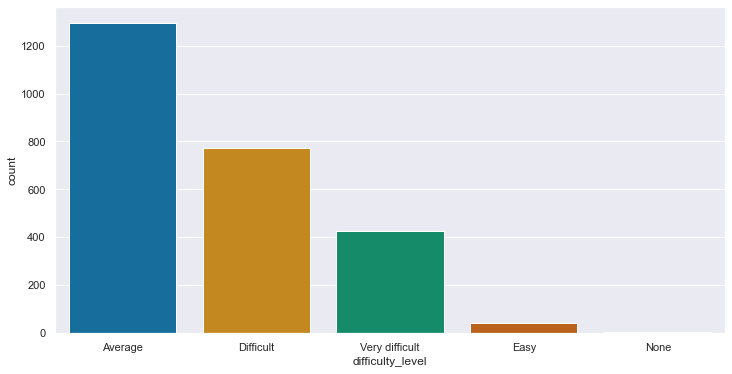

In [799]:
# figure size
plt.figure(figsize = (12, 6))

# count plot
sns.countplot(x = "difficulty_level", data = state_city_room_data)

## Success rate

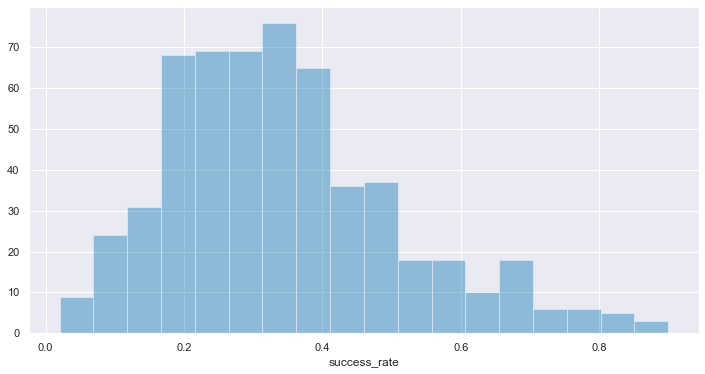

In [800]:
# figure size
plt.figure(figsize = (12, 6))

# count plot
sns.distplot(state_city_room_data["success_rate"].mask(state_city_room_data["success_rate"].eq("None")).dropna(), kde = False)

## Fear level

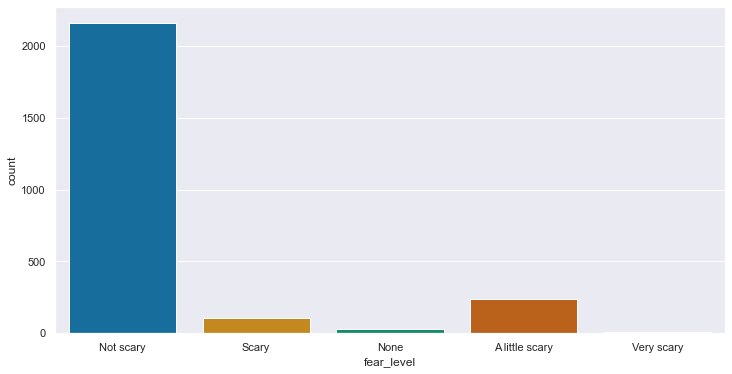

In [801]:
# figure size
plt.figure(figsize = (12, 6))

# count plot
sns.countplot(x = "fear_level", data = state_city_room_data)

## Age requirement

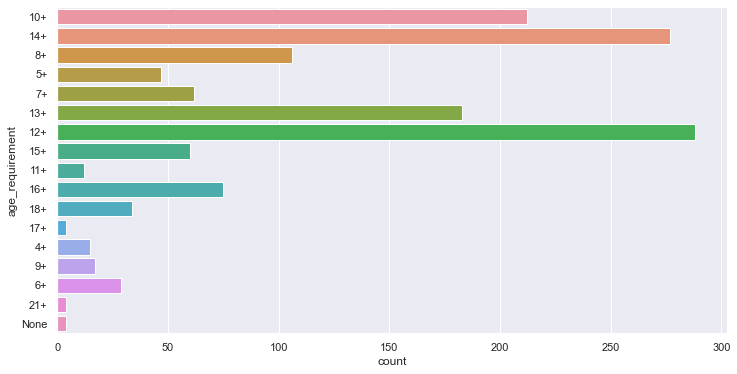

In [802]:
# figure size
plt.figure(figsize = (12, 6))

# count plot
sns.countplot(y = "age_requirement", data = state_city_room_data)

## Time limit

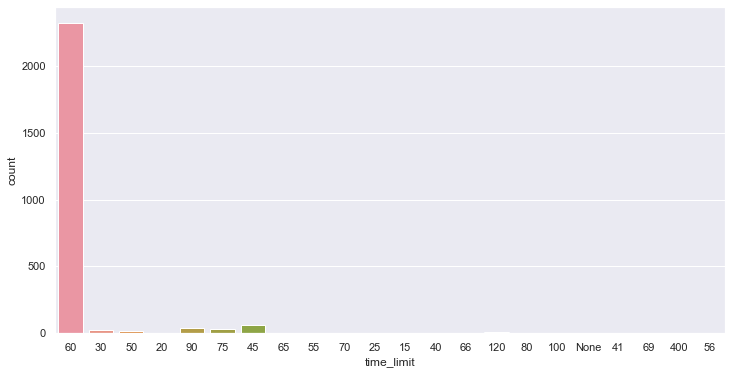

In [803]:
# figure size
plt.figure(figsize = (12, 6))

# histogram
sns.countplot(x = "time_limit", data = state_city_room_data)

## Minimum number of players

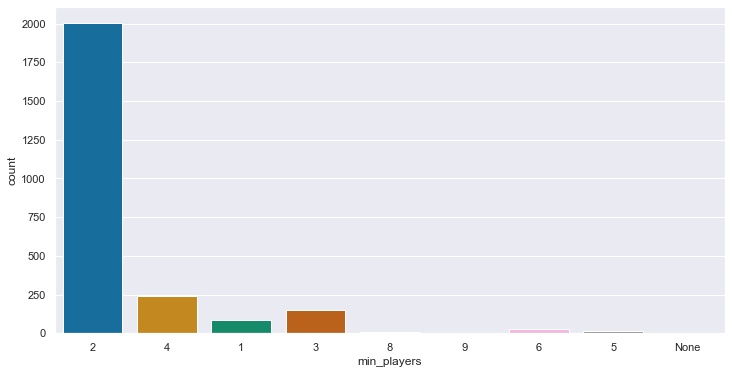

In [804]:
# figure size
plt.figure(figsize = (12, 6))

# count plot
sns.countplot(x = "min_players", data = state_city_room_data)

## Maximum number of players

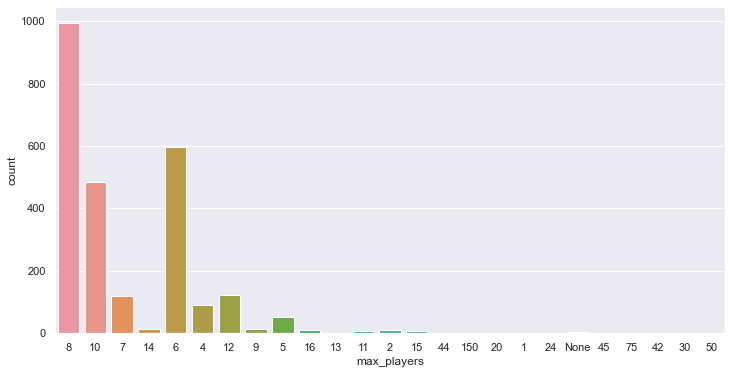

In [805]:
# figure size
plt.figure(figsize = (12, 6))

# count plot
sns.countplot(x = "max_players", data = state_city_room_data)

## Tags

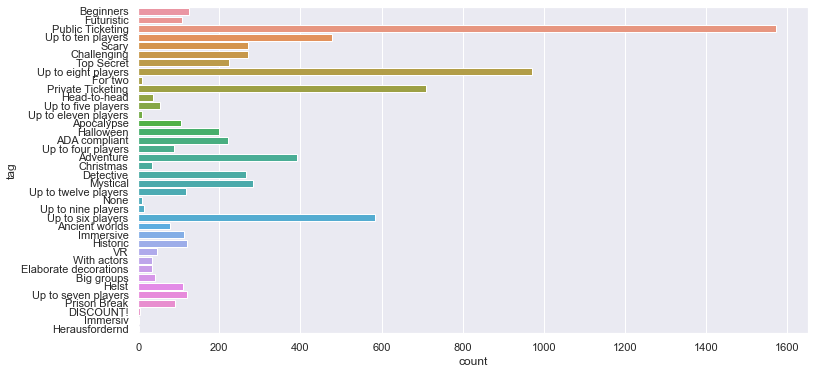

In [806]:
# figure size
plt.figure(figsize = (12, 6))

# count plot
sns.countplot(y = "tag", data = tag_data)

In [807]:
tag_data["tag"].unique()

array(['Beginners', 'Futuristic', 'Public Ticketing', 'Up to ten players',
       'Scary', 'Challenging', 'Top Secret', 'Up to eight players',
       'For two', 'Private Ticketing', 'Head-to-head',
       'Up to five players', 'Up to eleven players', 'Apocalypse',
       'Halloween', 'ADA compliant', 'Up to four players', 'Adventure',
       'Christmas', 'Detective', 'Mystical', 'Up to twelve players',
       'None', 'Up to nine players', 'Up to six players',
       'Ancient worlds', 'Immersive', 'Historic', 'VR', 'With actors',
       'Elaborate decorations', 'Big groups', 'Heist',
       'Up to seven players', 'Prison Break', 'DISCOUNT!', 'Immersiv',
       'Herausfordernd'], dtype=object)

# Room similarity

## Features

In [808]:
# features
features = ["min_players", "max_players", "time_limit", "difficulty_int", "success_rate", "fear_int"]

# See them
state_city_room_data.loc[:, features]

,min_players,max_players,time_limit,difficulty_int,success_rate,fear_int
0,2,8,60,1,0.62,0
1,2,8,60,2,0.54,0
2,4,8,60,1,None,0
3,2,10,60,2,0.55,0
4,2,8,60,1,0.53,0
...,...,...,...,...,...,...
2538,2,10,60,2,None,0
2539,2,7,60,2,None,0
2540,2,10,45,2,None,0
2541,2,10,45,2,None,0


## Test iterative imputer from sklearn

In [809]:
# full dataset of features
X_full = state_city_room_data.loc[:, features].mask(state_city_room_data.loc[:, features].eq("None"))

# imputer parameters (default estimator is BayesianRidge())
imputer = IterativeImputer(max_iter = 10, random_state = 39248)

# fit imputation model
imputer_fit = imputer.fit(X_full)

# predict missing values
X_predict = imputer_fit.transform(X_full)

# see results
pd.concat([pd.DataFrame(X_predict), state_city_room_data["company_and_room"]], ignore_index = True, axis = 1)

,0,1,2,3,4,5,6
0,2.0,8.0,60.0,1.0,0.620000,0.0,Auburn Escape Zones: Imprisoned
1,2.0,8.0,60.0,2.0,0.540000,0.0,Auburn Escape Zones: The Cabin
2,4.0,8.0,60.0,1.0,0.480629,0.0,Auburn Escape Zones: Vault
3,2.0,10.0,60.0,2.0,0.550000,0.0,Auburn Escape Zones: The Puzzler vs Superheroes
4,2.0,8.0,60.0,1.0,0.530000,0.0,Auburn Escape Zones: Black Beard's Brig
...,...,...,...,...,...,...,...
2538,2.0,10.0,60.0,2.0,0.348193,0.0,Escape Quest: The King’s Ransom
2539,2.0,7.0,60.0,2.0,0.344748,0.0,PanIQ Escape Room: Primal Quest
2540,2.0,10.0,45.0,2.0,0.337639,0.0,Escape Room Live: Ghostbusters!
2541,2.0,10.0,45.0,2.0,0.337639,0.0,Escape Room Live: Friday the 13th


## Euclidian distance matrix
Limitation: listwise deletion ...

In [810]:
pairwise_dist(state_city_room_data, features, "company_and_room")

company_and_room,Auburn Escape Zones: Imprisoned,Auburn Escape Zones: The Cabin,Auburn Escape Zones: Vault,Auburn Escape Zones: The Puzzler vs Superheroes,Auburn Escape Zones: Black Beard's Brig,Breakout Games: The Kidnapping,Breakout Games: Runaway Train,Breakout Games: Museum Heist,Breakout Games: Do Not Disturb,Breakout Games: Mystery Mansion,...,Smart Escape: The Ring,Insomnia Escape Room DC: Dungeon Things,The Great Escape Room: Professor Moriarty’s Gameroom,Escape Artist DC: Night at the Museum,Insomnia Escape Room DC: Oblivion,Escape Quest: The King’s Ransom,PanIQ Escape Room: Primal Quest,Escape Room Live: Ghostbusters!,Escape Room Live: Friday the 13th,Escape Room Live: Runaway Subway
company_and_room,,,,,,,,,,,,,,,,,,,,,
Auburn Escape Zones: Imprisoned,0.000000,1.421275,2.530070,1.475048,0.681425,0.977354,0.977354,2.441354,4.129801,2.441354,...,4.864987,2.475898,4.092876,2.475898,2.461058e+00,2.475898,2.461058,2.949008,2.949008,1.863476
Auburn Escape Zones: The Cabin,1.421275,0.000000,2.672629,0.497457,1.287971,1.352524,1.352524,1.469637,2.925635,1.469637,...,3.866378,1.533219,2.913802,1.533219,1.498632e+00,1.533219,1.498632,2.195572,2.195572,2.069163
Auburn Escape Zones: Vault,2.530070,2.672629,0.000000,2.731022,2.329694,2.315194,2.315194,2.825158,4.081210,2.825158,...,4.194323,2.861482,4.094048,2.861482,2.838972e+00,2.861482,2.838972,3.253615,3.253615,2.786368
Auburn Escape Zones: The Puzzler vs Superheroes,1.475048,0.497457,2.731022,0.000000,1.384846,1.539492,1.539492,1.621679,3.073229,1.621679,...,3.982737,1.527963,2.852660,1.527963,1.720161e+00,1.527963,1.720161,2.194663,2.194663,2.026106
Auburn Escape Zones: Black Beard's Brig,0.681425,1.287971,2.329694,1.384846,0.000000,0.361105,0.361105,1.896354,3.623297,1.896354,...,4.414738,1.946720,3.617803,1.946720,1.918569e+00,1.946720,1.918569,2.499478,2.499478,1.604482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Escape Quest: The King’s Ransom,2.475898,1.533219,2.861482,1.527963,1.946720,1.853008,1.853008,0.491969,1.884775,0.491969,...,3.067005,0.000000,1.684318,0.000000,7.379538e-01,0.000000,0.737954,1.495888,1.495888,2.237012
PanIQ Escape Room: Primal Quest,2.461058,1.498632,2.838972,1.720161,1.918569,1.717100,1.717100,0.245985,1.717100,0.245985,...,2.965293,0.737954,2.013968,0.737954,1.490116e-08,0.737954,0.000000,1.666759,1.666759,2.367277
Escape Room Live: Ghostbusters!,2.949008,2.195572,3.253615,2.194663,2.499478,2.418479,2.418479,1.573828,2.367277,1.573828,...,3.380633,1.495888,2.217992,1.495888,1.666759e+00,1.495888,1.666759,0.000000,0.000000,1.717100


# Mock-up data product

## Input 1: User address (e.g., where would you be coming from?)

In [811]:
user_address, user_latitude, user_longitude = get_lat_long("Phoenix, AZ")

# See them
print("Address: {} (Latitude: {}, Longitude: {})".format(user_address, user_latitude, user_longitude))

Address: Phoenix, AZ, USA (Latitude: 33.4483771, Longitude: -112.0740373)


## Input 2: User already played game (e.g., pick an escape room you've played before)

In [812]:
user_game = "Escape Rooms Mesa: Kate's Motel"

## Input 3: Distance willing to travel (miles) (e.g., how far are you willing to travel?)

In [813]:
travel_distance = 25

## Compute distance from user input address to all escape rooms 

In [814]:
room_distance = [distance.geodesic((user_latitude, user_longitude), (lat, long)).miles for lat, long in zip(state_city_room_data["room_latitude"], state_city_room_data["room_longitude"])]

# see some
room_distance[0:11]

[1542.7071723680674,
 1542.7071723680674,
 1542.7071723680674,
 1542.7071723680674,
 1542.7071723680674,
 1456.9213161886053,
 1456.9213161886053,
 1456.9213161886053,
 1456.9213161886053,
 1456.9213161886053,
 1456.9213161886053]

## Subset escape rooms based on distance

In [815]:
user_room_subset = state_city_room_data.loc[(np.array(room_distance) <= travel_distance), :]

## Compute distance matrix

In [816]:
user_distance_matrix = pairwise_dist(user_room_subset, features, index = "company_and_room")

# See it
user_distance_matrix

company_and_room,Great Room Escape: Spellbound,Dynamic Escape Rooms: The Secret Gallery (Quest to the Forbidden Temple),Escape Games AZ: The Secret Gallery (Quest to the Forbidden Temple),Escape Rooms Mesa: Kate's Motel,Escape Rooms Mesa: 51,Escape the Room: 51,Escape Games AZ: Doll House,Escape Rooms Mesa: Doll House,Dare to Escape AZ: The Bake Off,Great Escape Maricopa: The Bake Off,...,Escape the Room: Terminal,Escape the Room: Disco Fever!,Escape the Room: The Dig,Key Quest: Jurassic Escape,Escape Rooms Mesa: Outbreak,Escape Rooms Mesa: Steampunk,Riddle Escape Room: FBI Interview,Riddle Escape Room: Jack's Cabin,North Valley Escape Room: Dr. Riddler's Lab,Riddle Escape Room: Prison Break
company_and_room,,,,,,,,,,,,,,,,,,,,,
Great Room Escape: Spellbound,0.000000,4.176752,4.176752,7.279868,5.133953,5.133953e+00,4.069623,4.069623,4.642869,4.642869,...,2.558799,7.095245,3.984867,4.959753,4.959753,4.626166,4.799753,3.895049,4.989703,4.090415
Dynamic Escape Rooms: The Secret Gallery (Quest to the Forbidden Temple),4.176752,0.000000,0.000000,6.286321,2.132158,2.132158e+00,5.046341,5.046341,1.900848,1.900848,...,2.160136,5.722597,1.551810,1.728865,1.728865,1.941139,1.374037,3.533462,1.795289,1.792779
Escape Games AZ: The Secret Gallery (Quest to the Forbidden Temple),4.176752,0.000000,0.000000,6.286321,2.132158,2.132158e+00,5.046341,5.046341,1.900848,1.900848,...,2.160136,5.722597,1.551810,1.728865,1.728865,1.941139,1.374037,3.533462,1.795289,1.792779
Escape Rooms Mesa: Kate's Motel,7.279868,6.286321,6.286321,0.000000,6.953586,6.953586e+00,8.313129,8.313129,6.433226,6.433226,...,6.770192,2.693951,6.093384,6.912955,6.912955,6.033290,6.746520,7.048391,6.941593,5.862701
Escape Rooms Mesa: 51,5.133953,2.132158,2.132158,6.953586,0.000000,2.107342e-08,4.129021,4.129021,1.707314,1.707314,...,3.234465,6.051883,3.575282,0.922615,0.922615,2.733182,1.347519,2.940673,0.893711,3.657940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Escape Rooms Mesa: Steampunk,4.626166,1.941139,1.941139,6.033290,2.733182,2.733182e+00,5.282824,5.282824,2.631852,2.631852,...,2.895167,6.031577,2.581091,2.469193,2.469193,0.000000,2.327342,3.932702,2.504525,1.934813
Riddle Escape Room: FBI Interview,4.799753,1.374037,1.374037,6.746520,1.347519,1.347519e+00,4.697251,4.697251,2.206265,2.206265,...,2.545857,5.869093,2.900946,0.717486,0.717486,2.327342,0.000000,3.643643,0.817033,3.026943
Riddle Escape Room: Jack's Cabin,3.895049,3.533462,3.533462,7.048391,2.940673,2.940673e+00,2.687372,2.687372,2.231642,2.231642,...,3.690460,6.679028,4.137590,3.528469,3.528469,3.932702,3.643643,0.000000,3.523751,4.210878


## Rank game rooms by similarity

In [817]:
(user_distance_matrix
.loc[user_game]
.sort_values()
.to_frame()
.reset_index(level = 0)
.rename(columns = {"index": "company_and_room", user_game: "distance"}))

,company_and_room,distance
0,Escape Rooms Mesa: Kate's Motel,0.000000
1,Escape the Room: Disco Fever!,2.693951
2,Escape Room 101: Jekyll and Hyde,2.994352
3,Cluemaster Escape Rooms: Hansel & Gretel: Chap...,5.735258
4,Eludesions Escape Rooms: Outbreak!,5.784868
...,...,...
117,Escape House: The Time Machine: Nemesis,8.352118
118,ESCAPE:chandler: Hospital of Horror VR,8.567078
119,Escape Zone: Private Detective Agency: Knight ...,8.941938
120,Escape the Room: Detention,10.174747


## Return 3 similar and 3 different escape rooms

In [818]:
user_recommendations, user_distances = user_distance_matrix.loc[user_game].sort_values().index[[0, 1, 2, 3, 119, 120, 121]].tolist(), user_distance_matrix.loc[user_game].sort_values().values[[0, 1, 2, 3, 119, 120, 121]].tolist()

# see them
for recommendation, distance in zip(user_recommendations, user_distances):
    print("Recommendation {} (Dissimilarity: {})".format(recommendation, distance))

Recommendation Escape Rooms Mesa: Kate's Motel (Dissimilarity: 0.0)
Recommendation Escape the Room: Disco Fever! (Dissimilarity: 2.693950977757314)
Recommendation Escape Room 101: Jekyll and Hyde (Dissimilarity: 2.9943523328771526)
Recommendation Cluemaster Escape Rooms: Hansel & Gretel: Chapter 2 (Dissimilarity: 5.735258158720316)
Recommendation Escape Zone: Private Detective Agency: Knight & Rook Investigations (Dissimilarity: 8.941938087377821)
Recommendation Escape the Room: Detention (Dissimilarity: 10.174747476191053)
Recommendation International Room Escape AZ: Monkey Business (Dissimilarity: 10.284705035476927)


## Face validity (check (dis)similarity next to actual features)

In [819]:
state_city_room_data.loc[(state_city_room_data["company_and_room"].isin(user_recommendations)) | (state_city_room_data["company_and_room"] == user_game), ["company_and_room", "max_players", "time_limit", "difficulty_int", "success_rate", "fear_int"]]

,company_and_room,max_players,time_limit,difficulty_int,success_rate,fear_int
130,Escape Rooms Mesa: Kate's Motel,8,90,3,0.2,0
168,Escape Zone: Private Detective Agency: Knight ...,6,45,2,0.26,0
177,Escape the Room: Detention,6,45,0,None,0
218,Cluemaster Escape Rooms: Hansel & Gretel: Chap...,8,60,3,None,0
222,Escape Room 101: Jekyll and Hyde,6,90,2,None,0
241,International Room Escape AZ: Monkey Business,6,45,0,None,0
247,Escape the Room: Disco Fever!,10,90,2,None,0


In [820]:
# Remember the user input game
user_game

"Escape Rooms Mesa: Kate's Motel"

## Combine steps in one function

In [821]:
def recommend_rooms(user_location, travel_limit, room_played, features = ["min_players", "max_players", "time_limit", "difficulty_int", "success_rate", "fear_int"], other_var = ["query_address", "woe_room_url", "miles2room"]):
    # user location data
    user_address_query, user_latitude, user_longitude = get_lat_long(user_location)
    
    # compute miles away from each room in database
    miles2room = [distance.geodesic((user_latitude, user_longitude), (room_latitude, room_longitude)).miles for room_latitude, room_longitude in zip(state_city_room_data["room_latitude"], state_city_room_data["room_longitude"])]
    
    # add to data frame
    state_city_room_data["miles2room"] = miles2room
    
    # subset escape room database to rooms within travel limit
    # note that is same length of data frame
    escape_rooms_subset = state_city_room_data.loc[np.array(miles2room) <= travel_limit, :]
    
    # z-score features and compute pairwise euclidian distance matrix
    escape_room_distances = pairwise_dist(escape_rooms_subset, features, "company_and_room")
    
    # rank rooms based on similarity to room user input
    rooms_ranked = (escape_room_distances.loc[room_played]
    .sort_values()
    .to_frame()
    .reset_index(level = 0)
    .rename(columns = {"index": "company_and_room", room_played: "distance"}))
 
    # left join with subset of escape rooms
    escape_rooms_subset = rooms_ranked.merge(escape_rooms_subset, how = "left", on = "company_and_room")
 
    # 3 most similar and 3 most dissimilar
    recommended_rooms = rooms_ranked["company_and_room"].values[:4].tolist() + rooms_ranked["company_and_room"].values[-3:].tolist()
 
    return escape_rooms_subset.loc[escape_rooms_subset["company_and_room"].isin(recommended_rooms), other_var + ["distance"] + features].sort_values(by = "distance")

### Test `recommend_rooms()` function

In [824]:
recommend_rooms(user_location = "Phoenix, AZ", travel_limit = 25, room_played = "Escape Rooms Mesa: Kate's Motel", features = ["min_players", "max_players", "time_limit", "difficulty_int", "success_rate", "fear_int"], other_var = ["query_address", "woe_room_url", "miles2room"])

,query_address,woe_room_url,miles2room,distance,min_players,max_players,time_limit,difficulty_int,success_rate,fear_int
0,"312 N Alma School Rd #9, Chandler, AZ 85224, USA",https://worldofescapes.com/phoenix/quests/esca...,15.701805,0.000000,4,8,90,3,0.2,0
1,"86 W University Dr #100, Mesa, AZ 85201, USA",https://worldofescapes.com/phoenix/quests/esca...,13.994312,2.693951,2,10,90,2,None,0
2,"86 W University Dr #100, Mesa, AZ 85201, USA",https://worldofescapes.com/phoenix/quests/esca...,13.994312,2.994352,2,6,90,2,None,0
3,"86 W University Dr #100, Mesa, AZ 85201, USA",https://worldofescapes.com/phoenix/quests/esca...,13.994312,5.735258,4,8,60,3,None,0
119,"1422 W Warner Rd Space A 102, Gilbert, AZ 8523...",https://worldofescapes.com/phoenix/quests/phoe...,16.542914,8.941938,2,6,45,2,0.26,0
120,"3335 W Peoria Ave, Phoenix, AZ 85029, USA",https://worldofescapes.com/phoenix/quests/key-...,9.721496,10.174747,3,6,45,0,None,0
121,"12 N Center St #200, Mesa, AZ 85201, USA",https://worldofescapes.com/phoenix/quests/esca...,14.179610,10.284705,2,6,45,0,None,0
